Data source: https://github.com/nbertagnolli/counsel-chat/tree/master/data

Original blog post for counsel chat: https://towardsdatascience.com/counsel-chat-bootstrapping-high-quality-therapy-data-971b419f33da



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

#Analysing counselchat-data.csv

In [ ]:
#load the input data files
counselchat_df = pd.read_csv('/content/drive/My Drive/Omdena/Paris/Chatbot_Elderly/CounselChat/Data/counselchat-data.csv')

Let's see the number of datapoints and the features

In [ ]:
counselchat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482 entries, 0 to 1481
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   questionID     1482 non-null   object
 1   questionTitle  1480 non-null   object
 2   questionText   1383 non-null   object
 3   questionUrl    1482 non-null   object
 4   topics         1472 non-null   object
 5   therapistName  1482 non-null   object
 6   therapistUrl   1482 non-null   object
 7   answerText     1482 non-null   object
 8   upvotes        1482 non-null   int64 
dtypes: int64(1), object(8)
memory usage: 104.3+ KB


From a cursory glance, there are about 1500 datapoints with 8 features(excluding questionID which is just an identity market and not a feature). Of these 8 features, **questionTitle and answerText** are the most useful ones for constructing a chatbot. However, we will still analyze the other features as well to better understand the data. This understanding may come handy in future analyses of both data and model. **therapistUrl and questionUrl** features are not so useful for the current analyses. As such, we drop the 3 features **questionID therapistUrl, and questionUrl**

An interesting observation is that *upvotes* feature only has 0 values. So, this feature is not so useful to understand the data. We drop this feature

In [ ]:
counselchat_df[['upvotes']].value_counts()

upvotes
0          1482
dtype: int64

In [ ]:
##dropping currently unncessary features
counselchat_df_mod = counselchat_df.drop(['questionID', 'therapistUrl',  'questionUrl', 'upvotes'], axis = 1,).copy()
counselchat_df_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482 entries, 0 to 1481
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   questionTitle  1480 non-null   object
 1   questionText   1383 non-null   object
 2   topics         1472 non-null   object
 3   therapistName  1482 non-null   object
 4   answerText     1482 non-null   object
dtypes: object(5)
memory usage: 58.0+ KB


We can see **questionTitle, questionText, and topics** have some missing values. let's analyze the amount of missing values for these 3 columns

In [ ]:
df_with_nan_vals = counselchat_df_mod[['questionTitle', 'questionText', 'topics']]
null_df = df_with_nan_vals.isnull().sum()
null_df = pd.DataFrame(null_df)
null_df.reset_index(inplace=True)
null_df.columns = ['Features', 'Null vals']
null_df['null percentage'] =( null_df['Null vals']/counselchat_df_mod.shape[0])*100
null_df

,Features,Null vals,null percentage
0,questionTitle,2,0.134953
1,questionText,99,6.680162
2,topics,10,0.674764


Both **questionTitle and topics** have less than 1% missing values while **questionText** has below 7% missing values. it's safe to assume the amount of missing data is not that concerning.

Let's now analyze the unique values for **topics and therapistName**. 

In [ ]:
counselchat_df_mod[['topics', 'therapistName']].nunique()

topics           288
therapistName    159
dtype: int64

This dataset contains answers from 160 therapists spanning across about 290 topics. Let's us explore who provides the most answers and on which topic.

##Topic Analysis

In [ ]:
topic_df =  pd.DataFrame(counselchat_df_mod[['topics']].value_counts()).reset_index()
topic_df.columns = ['topics', 'count']
topic_df['percentage'] = topic_df['count'] * 100 / counselchat_df_mod.shape[0]
topic_df.style.background_gradient(cmap='YlOrRd')

,topics,count,percentage
0,Relationships,116,7.827260
1,Depression,68,4.588394
2,Anxiety,46,3.103914
3,Counseling Fundamentals,39,2.631579
4,"Relationships,Intimacy",37,2.496626
5,Family Conflict,37,2.496626
6,Parenting,35,2.361673
7,Behavioral Change,34,2.294197
8,Self-esteem,29,1.956815
9,LGBTQ,29,1.956815


It's clear that not all topics are equally covered. While a lot of the topics involve relationships, topics like queer intimacy cover only a single post. Let's draw a treemap from plotly library to get a better picture of how frequently diverse topics are covered.

In [ ]:
import plotly.express as px
fig = px.treemap(topic_df, path=['topics', 'count'], values='count',title='Topic Count Analysis')
fig.show()

 Most discussions are concentrated around a handful of topics. Topics such as relationships, anxiety, depresions, etc. are prominent in this dataset. Let's see which topics entail more than 10 datapoints.

In [ ]:
topic_df[topic_df['count']>10].style.background_gradient(cmap='YlOrRd')

,topics,count,percentage
0,Relationships,116,7.827260
1,Depression,68,4.588394
2,Anxiety,46,3.103914
3,Counseling Fundamentals,39,2.631579
4,"Relationships,Intimacy",37,2.496626
5,Family Conflict,37,2.496626
6,Parenting,35,2.361673
7,Behavioral Change,34,2.294197
8,Self-esteem,29,1.956815
9,LGBTQ,29,1.956815


So, 25 topics have over 10 discussions. 

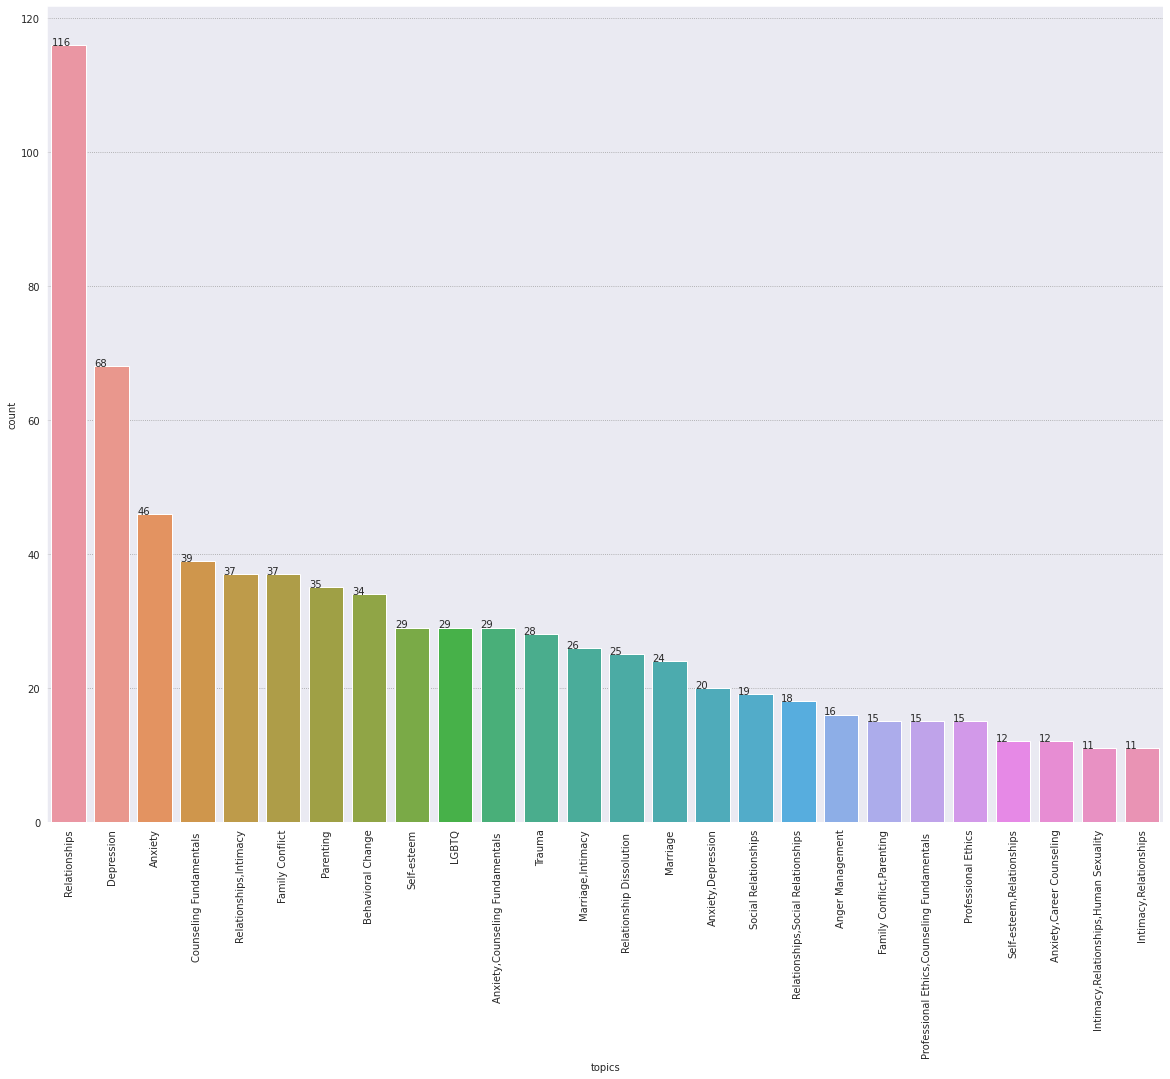

In [ ]:
topic_df_over_10 = topic_df[topic_df['count']>10]
fig, ax = plt.subplots(figsize=(20,15))
plt.xticks(rotation=90, fontsize='10')
sns.barplot(x = 'topics', y = 'count', data = topic_df_over_10, ax= ax)
for p, label in zip(ax.patches, counselchat_df_mod["topics"].value_counts()):   
    ax.annotate(label, (p.get_x(), p.get_height()))

Some of the most focused topics discussed in the dataset are:
- Relationships
- Depression
- Anxiety
- Counselling
- Family Conflict
- Parenting

This may represent that more people have to deal with these issues compared to queer intimacy or relationships involving substance abuse

##Therepist Analysis

In [ ]:
therapist_df =  pd.DataFrame(counselchat_df_mod[['therapistName']].value_counts()).reset_index()
therapist_df.columns = ['therapistName', 'count']
therapist_df['percentage'] = therapist_df['count'] * 100 / counselchat_df_mod.shape[0]
therapist_df.style.background_gradient(cmap='YlOrRd')

,therapistName,count,percentage
0,"Sherry Katz, LCSW",275,18.556005
1,"Lauren Ostrowski, MA, LPC, NCC, DCC, CCTP",144,9.716599
2,Lynda Martens,127,8.569501
3,"Robin Landwehr, DBH, LPCC, NCC",45,3.036437
4,Sonya Wilson,44,2.968961
5,"Eric Ström, JD, MA, LMHC",39,2.631579
6,"Vivian D. Echevarria Guzman, MSC, LPC, NCC",38,2.564103
7,Ben Braaksma,35,2.361673
8,Rebecca Wong,32,2.159244
9,"Kristi King-Morgan, LMSW",32,2.159244


Similar to topics, A handful of therapists provide a large chunk of the answers. 

In [ ]:
import plotly.express as px
fig = px.treemap(therapist_df, path=['therapistName', 'count'], values='count',title='Therapist Response Count Analysis', color='count', color_continuous_scale='RdBu',
                  color_continuous_midpoint=np.average(lynda_topic_df['count']))
fig.show()

**Sherry Katz** has provided more answers than any other therapist followed by **Lauren Ostrowski** and **Lynda Martens**. It could also represent that these therapists are more popular than the others. 

In [ ]:
therapist_df[therapist_df['count']>10].style.background_gradient(cmap='YlOrRd')

,therapistName,count,percentage
0,"Sherry Katz, LCSW",275,18.556005
1,"Lauren Ostrowski, MA, LPC, NCC, DCC, CCTP",144,9.716599
2,Lynda Martens,127,8.569501
3,"Robin Landwehr, DBH, LPCC, NCC",45,3.036437
4,Sonya Wilson,44,2.968961
5,"Eric Ström, JD, MA, LMHC",39,2.631579
6,"Vivian D. Echevarria Guzman, MSC, LPC, NCC",38,2.564103
7,Ben Braaksma,35,2.361673
8,Rebecca Wong,32,2.159244
9,"Kristi King-Morgan, LMSW",32,2.159244


A little above 20 therapists provde more than 10 answers. 

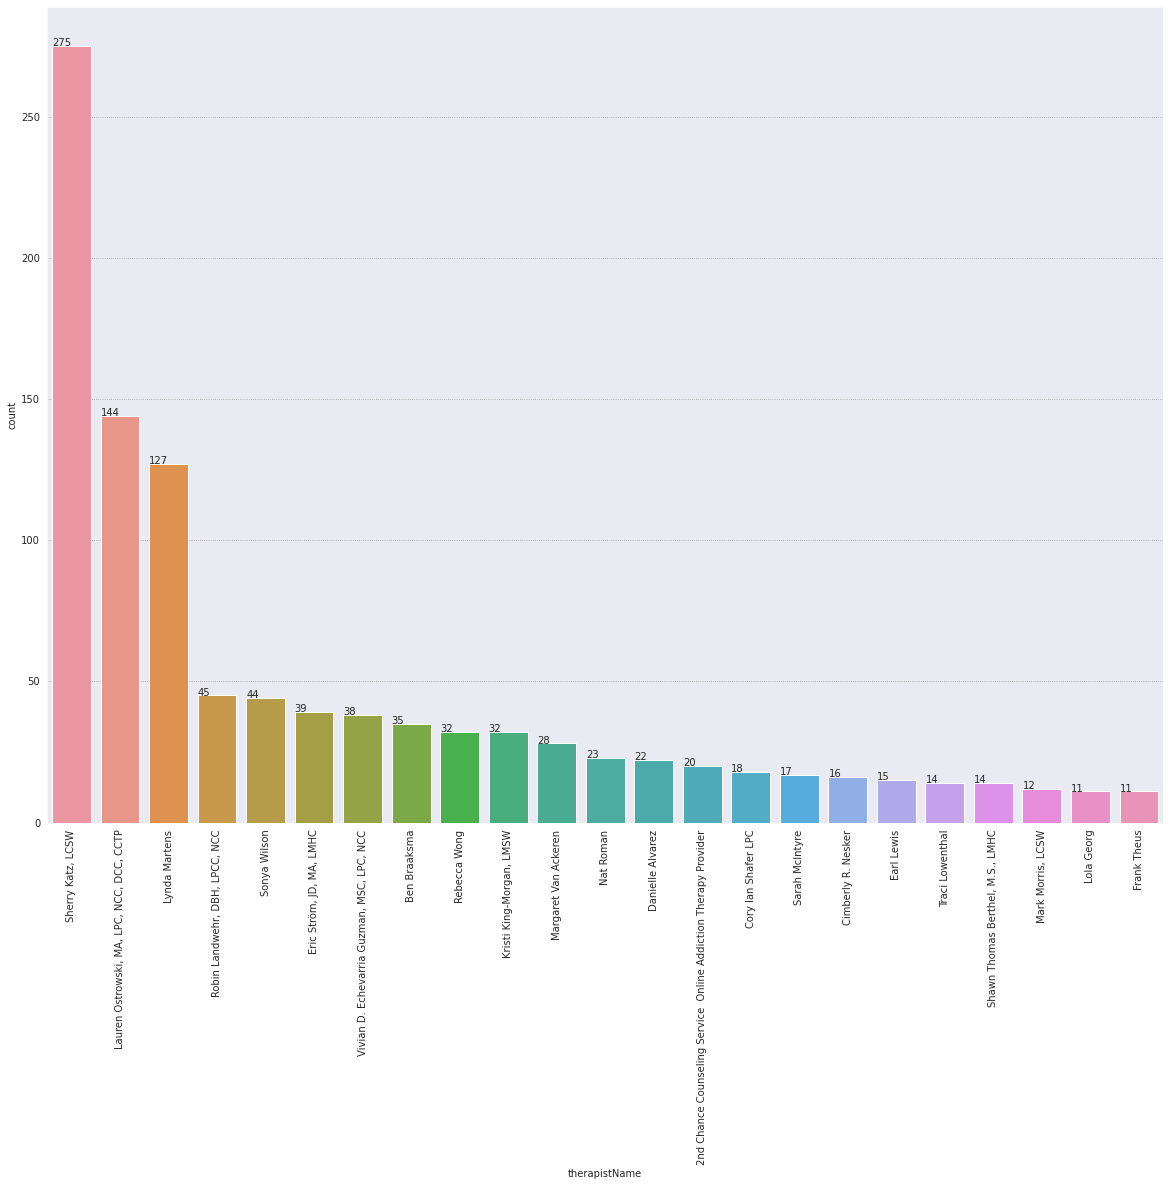

In [ ]:
therapist_df_over_10 = therapist_df[therapist_df['count']>10]
fig, ax = plt.subplots(figsize=(20,15))
plt.xticks(rotation=90, fontsize='10')
sns.barplot(x = 'therapistName', y = 'count', data = therapist_df_over_10, ax= ax)
for p, label in zip(ax.patches, counselchat_df_mod["therapistName"].value_counts()):   
    ax.annotate(label, (p.get_x(), p.get_height()))

##Top 3 Therapist Topic Analysis

We can further analyze what topics the top 3 therapists: Sherry Katz, Lauren Ostrowski, and Lynda Martens, cover in their answers.

In [ ]:
topic_therapist_df = counselchat_df_mod[['therapistName', 'topics']].copy()

### Sherry Katz

In [ ]:
sherry_katz_df = topic_therapist_df[topic_therapist_df.therapistName == 'Sherry Katz, LCSW'].copy()
sherry_katz_topic_df =  pd.DataFrame(sherry_katz_df[['topics']].value_counts()).reset_index()
sherry_katz_topic_df.columns = ['topics', 'count']
sherry_katz_topic_df.style.background_gradient(cmap='PuBu')

,topics,count
0,Relationships,27
1,Anxiety,10
2,Depression,10
3,Parenting,8
4,"Family Conflict,Parenting",7
5,"Relationships,Intimacy",7
6,Social Relationships,6
7,"Marriage,Intimacy",6
8,Counseling Fundamentals,5
9,Relationship Dissolution,5


In [ ]:
fig = px.treemap(sherry_katz_topic_df, path=['topics', 'count'], values='count',title='Sherry Katz Topic Count Analysis', color='count', color_continuous_scale='RdBu',
                  color_continuous_midpoint=np.average(lynda_topic_df['count']))
fig.show()

Sherry Katz appears to offer answers on diverse topics 

###Lauren Ostrowski

In [ ]:
lauren_df = topic_therapist_df[topic_therapist_df.therapistName == 'Lauren Ostrowski, MA, LPC, NCC, DCC, CCTP'].copy()
lauren_topic_df =  pd.DataFrame(lauren_df[['topics']].value_counts()).reset_index()
lauren_topic_df.columns = ['topics', 'count']
lauren_topic_df.style.background_gradient(cmap='PuBu')

,topics,count
0,Depression,11
1,"Relationships,Intimacy",10
2,Behavioral Change,10
3,Relationships,7
4,Family Conflict,7
5,Relationship Dissolution,6
6,Anxiety,5
7,Parenting,5
8,LGBTQ,4
9,"Self-esteem,Depression",3


In [ ]:
fig = px.treemap(lauren_topic_df, path=['topics', 'count'], values='count',title='Lauren Ostrowski Topic Count Analysis', color='count', color_continuous_scale='RdBu',
                  color_continuous_midpoint=np.average(lynda_topic_df['count']))
fig.show()

Similar to Sherry Katz, Lauren Ostrowski appears to offer answers on diverse topics 

### Lynda Martens

In [ ]:
lynda_df = topic_therapist_df[topic_therapist_df.therapistName == 'Lynda Martens'].copy()
lynda_topic_df =  pd.DataFrame(lynda_df[['topics']].value_counts()).reset_index()
lynda_topic_df.columns = ['topics', 'count']
lynda_topic_df.style.background_gradient(cmap='YlOrRd')

,topics,count
0,Relationships,15
1,"Relationships,Intimacy",11
2,Family Conflict,7
3,Parenting,7
4,Depression,5
5,"Marriage,Intimacy",5
6,Marriage,4
7,LGBTQ,2
8,Behavioral Change,2
9,Professional Ethics,2


In [ ]:
fig = px.treemap(lynda_topic_df, path=['topics', 'count'], values='count',title='Sherry Katz Topic Count Analysis', 
                 color='count', color_continuous_scale='RdBu',
                  color_continuous_midpoint=np.average(lynda_topic_df['count']))
fig.show()

Unlike Sherry and Lauren, Lynda Martens seems to focus on relationship therapy.

#Analysing 20200325_counsel_chat.csv

In [ ]:
#load the input data files
counselchat_df = pd.read_csv('/content/drive/My Drive/Omdena/Paris/Chatbot_Elderly/CounselChat/Data/20200325_counsel_chat.csv')

In [ ]:
counselchat_df.shape

(2129, 12)

In [ ]:
counselchat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     2129 non-null   int64 
 1   questionID     2129 non-null   int64 
 2   questionTitle  2129 non-null   object
 3   questionText   2129 non-null   object
 4   questionLink   2129 non-null   object
 5   topic          2129 non-null   object
 6   therapistInfo  2129 non-null   object
 7   therapistURL   2129 non-null   object
 8   answerText     2129 non-null   object
 9   upvotes        2129 non-null   int64 
 10  views          2129 non-null   int64 
 11  split          2129 non-null   object
dtypes: int64(4), object(8)
memory usage: 199.7+ KB


In [ ]:
counselchat_df.shape

(2129, 12)

In [ ]:
counselchat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     2129 non-null   int64 
 1   questionID     2129 non-null   int64 
 2   questionTitle  2129 non-null   object
 3   questionText   2129 non-null   object
 4   questionLink   2129 non-null   object
 5   topic          2129 non-null   object
 6   therapistInfo  2129 non-null   object
 7   therapistURL   2129 non-null   object
 8   answerText     2129 non-null   object
 9   upvotes        2129 non-null   int64 
 10  views          2129 non-null   int64 
 11  split          2129 non-null   object
dtypes: int64(4), object(8)
memory usage: 199.7+ KB


In [ ]:
counselchat_df.head(5)

In [ ]:
counselchat_df_mod= counselchat_df.drop(['questionID', 'therapistURL',  'questionLink'], axis = 1,).copy()

We drop the columns **questionID, questionLink, therapistURL** because they hardly convey any insight into the data

##Dataset Split Analysis

In [ ]:
split_df = counselchat_df[['split']].value_counts().reset_index()
split_df.columns = ['split', 'count']
split_df['percentage'] = split_df['count'] * 100 / counselchat_df_mod.shape[0]
split_df.style.background_gradient(cmap='YlOrRd')

,split,count,percentage
0,train,1839,86.378581
1,val,173,8.125881
2,test,117,5.495538


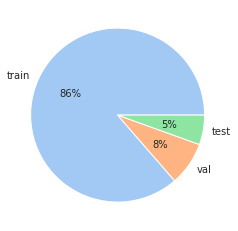

In [ ]:
colors = sns.color_palette('pastel')[0:3]
plt.pie(split_df['count'].values, labels = split_df['split'].values, colors = colors, autopct='%.0f%%')
plt.show()

##Upvotes Analysis

In [ ]:
upvote_df = counselchat_df[['upvotes']].value_counts().reset_index()
upvote_df.columns = ['upvotes', 'count']
upvote_df['percentage'] = upvote_df['count'] * 100 / counselchat_df_mod.shape[0]
upvote_df.style.background_gradient(cmap='YlOrRd')

,upvotes,count,percentage
0,0,1468,68.952560
1,1,429,20.150305
2,2,153,7.186473
3,3,40,1.878816
4,4,26,1.221231
5,5,7,0.328793
6,9,4,0.187882
7,6,1,0.046970
8,7,1,0.046970


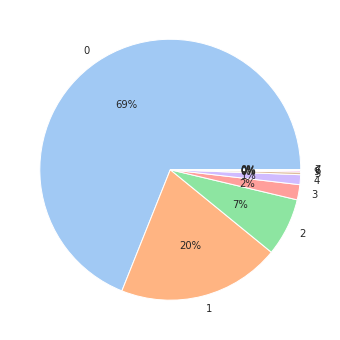

In [ ]:
colors = sns.color_palette('pastel')[0:8]
fig, ax = plt.subplots(figsize=(6,6))
ax.pie(upvote_df['count'].values, labels = upvote_df['upvotes'].values, colors = colors, autopct='%.0f%%')
plt.show()

Majority of posts didn't receive any upvotes. About 20% posts received 1 upvotes while 7% posts received 2 upvotes. The rest of the posts recevied more than 2 upvotes. 

Only 1 post received 7 upvotes(the highest upvotes). Let's check out that post.

In [ ]:
counselchat_df_mod[counselchat_df_mod.upvotes ==7]['questionTitle']

1751    The Underlying Causes of Being Possessive
Name: questionTitle, dtype: object

In [ ]:
counselchat_df_mod[counselchat_df_mod.upvotes ==7]['questionText'].values[0]

'I am extremely possessive in my relationships and this is hurting my friendships. How can I fix my underlying issues?'

In [ ]:
counselchat_df_mod[counselchat_df_mod.upvotes ==7]['answerText'].values[0]

'Hi there. It\'s great you are able to realize there are other issues going on with someone who feels possessive. At the root of it is fear. Fear of losing someone, fear of being alone, fear of not being good enough. All those fears can lead to low self-esteem and feeling like you have to control other people so you don\'t lose them. The thing is, controlling other people only pushes them away. Vicious circle, right?\xa0What I would suggest is some cognitive therapy to change those underlying ways of thinking. You can start with this assignment. Write down all the things you think about yourself, positive and not-so-positive. Then rewrite those not-so-positive things so they are positive. For example, thinking something like, "I\'m too pushy", can be rewritten as, "I\'m assertive and I go after what I want." It can be hard to do since we tend to get "stuck" in our negative ways of thinking about ourselves. If you have someone you trust, you can ask for their help as well since most lik

In [ ]:
counselchat_df_mod[counselchat_df_mod.upvotes ==7]['therapistInfo'].values[0]

'Rebecca DuellmanMA, Applied Psychology, Specializing in Forensic Psychology issues.'

##Missing Values Analysis

In [ ]:
counselchat_df_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     2129 non-null   int64 
 1   questionTitle  2129 non-null   object
 2   questionText   2129 non-null   object
 3   topic          2129 non-null   object
 4   therapistInfo  2129 non-null   object
 5   answerText     2129 non-null   object
 6   upvotes        2129 non-null   int64 
 7   views          2129 non-null   int64 
 8   split          2129 non-null   object
dtypes: int64(3), object(6)
memory usage: 149.8+ KB


It seems there is no missing values in this data

The dataset covers 31 topics and the queries are answered by 307 therapists.

In [ ]:
counselchat_df_mod[['topic', 'therapistInfo']].nunique()

topic             31
therapistInfo    307
dtype: int64